**Importing the libraries needed** 

In [1]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import itertools
from numpy import loadtxt
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

**Connecting to google drive**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


 
**Uploading the dataset**

In [3]:
path_data = "/content/gdrive/MyDrive/thesis/modified.csv"

Arsas = pd.read_csv(path_data ,sep='\t')

In [4]:
data = Arsas

**printing the first 3 rows of the data**

In [5]:
data.head(3)

,#Tweet_ID,Tweet_text,Sentiment_label
0,929241870508724224,المباراة القـادمة #غانا x #مصر الجولة الأخيرة ...,Positive
1,928942264583376897,هل هذه هي سياسة خارجيه لدوله تحترم نفسها والآخ...,Negative
2,928615163250520065,وزير خارجية فرنسا عن منتدى شباب العالم: شعرت ب...,Positive


**printing the shape of the dataset nbr of row and columns**

In [6]:
print("Data contient {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Data contient 21064 lignes et 3 colonnes.


 **printing the fiels with missed values**



In [7]:
data.isnull().sum()

#Tweet_ID          0
Tweet_text         0
Sentiment_label    0
dtype: int64

**printing the number of the duplicated rows**

In [8]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  68 doublons dans Data.


In [9]:
data.drop_duplicates(inplace = True)

In [10]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  0 doublons dans Data.


**checking the types of the fiels in the data**

In [11]:
data.dtypes

#Tweet_ID           int64
Tweet_text         object
Sentiment_label    object
dtype: object

**function for printing the pie**

In [12]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

**Counting the % of each classe**

In [13]:
data.Sentiment_label.value_counts(normalize = True)

Negative    0.371404
Neutral     0.346018
Positive    0.220566
Mixed       0.062012
Name: Sentiment_label, dtype: float64

**Printing the distribution of the classes**

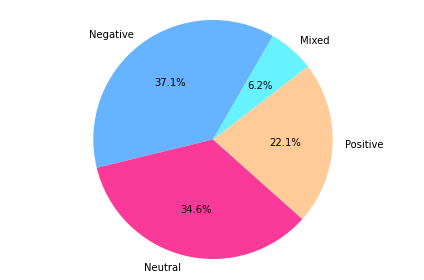

In [14]:
pie(data, "Sentiment_label")

In [15]:
positive = data[data["Sentiment_label"] == "Positive"]
positive["sentiment"] = 1

mixed = data[data["Sentiment_label"] == "Mixed"]
mixed["sentiment"] = 2

neutral = data[data["Sentiment_label"] == "Neutral"]
neutral["sentiment"] = 3

negative = data[data["Sentiment_label"] == "Negative"]
negative["sentiment"] = 0

data = pd.concat([positive, mixed, neutral, negative], ignore_index = True)

In [16]:
print("data contient {} lignes.".format(data.shape[0]))

print("Positive contient {} lignes.".format(positive.shape[0]))

print("Negative contient {} lignes.".format(negative.shape[0]))

print("Mixed contient {} lignes.".format(mixed.shape[0]))

print("Neutral contient {} lignes.".format(neutral.shape[0]))

data contient 20996 lignes.
Positive contient 4631 lignes.
Negative contient 7798 lignes.
Mixed contient 1302 lignes.
Neutral contient 7265 lignes.


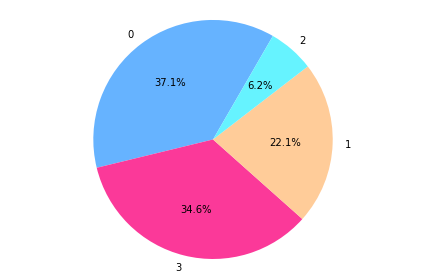

In [17]:
pie(data,"sentiment")

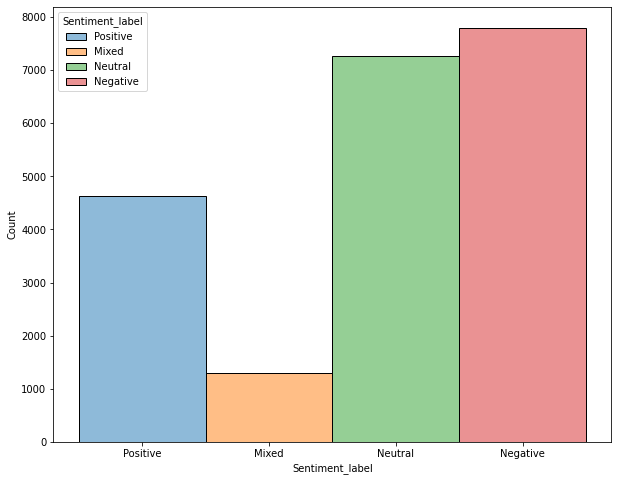

In [18]:
histo(data,"Sentiment_label")

**function to count the length of reviews**



In [19]:
def compte_mots(phrase):
    return len(phrase.split())

data["len_review"] = data["Tweet_text"].apply(compte_mots)


**printing the max  length of the positive and negative reviews**

In [20]:
print("Le maximum de mots utilisé dans les reviews  est :", max(data['len_review']))
print("Le moyen de mots utilisé dans les reviews est :", np.mean(data['len_review']))

Le maximum de mots utilisé dans les reviews  est : 64
Le moyen de mots utilisé dans les reviews est : 19.701657458563535


(0.0, 100.0)

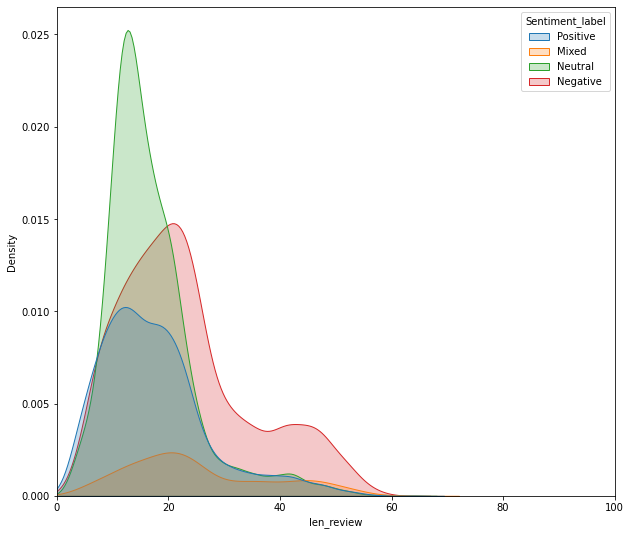

In [21]:
plt.figure(figsize=(10,9))

p1=sns.kdeplot(data['len_review'], hue = data['Sentiment_label'],  shade=True, color="r")

plt.xlim(0, 100)

**Deleting unused fields**

In [22]:
data.drop(['#Tweet_ID'], axis = 1, inplace = True)
data.head(3)

,Tweet_text,Sentiment_label,sentiment,len_review
0,المباراة القـادمة #غانا x #مصر الجولة الأخيرة ...,Positive,1,45
1,وزير خارجية فرنسا عن منتدى شباب العالم: شعرت ب...,Positive,1,16
2,بسم الله نبدأ 👏 نغرد علي وسم 👇 👇 👇 👇 👇 ↩ #شباب...,Positive,1,27


In [23]:
df = data
df.dtypes

Tweet_text         object
Sentiment_label    object
sentiment           int64
len_review          int64
dtype: object

**the function of the preprocessing**

In [24]:
def preprocessing(text):
     
    # ref: https://github.com/bakrianoo/aravec
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
    
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
    
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"[a-zA-Z]", '', text)
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    text = text.strip()
    
    return text



**preprocessing the reviews and printing the time spent**

In [25]:
%%time
data["Clean_reviews"] = data.Tweet_text.apply(lambda x: preprocessing(x))

CPU times: user 1.06 s, sys: 8.81 ms, total: 1.07 s
Wall time: 1.08 s


**printing a review before and after preprocessing**

In [26]:
print('- Avant le prétraitement \n\n',data["Tweet_text"][4])
print("\n-----------------------------------------------\n")
print('- Après le prétraitement \n\n',data["Clean_reviews"][4])

- Avant le prétraitement 

 شارك بتصويت «BBC» لدعم محمد صلاح للحصول على جائزة الأفضل بأفريقيا https://t.co/t1Q0l0UlP

-----------------------------------------------

- Après le prétraitement 

 شارك بتصويت لدعم محمد صلاح للحصول علي جائزه الافضل بافريقيا


**Saving the cleaned data in a csv file**

In [27]:
data.to_csv("cleaned_Arsas.csv")

**asigning the reviews and classes to a new variables**




In [28]:

X = data.Clean_reviews
y=pd.get_dummies(data.sentiment)
# y = data.sentiment

**spliting the data to train and test set**



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

**printing the number of the train set and the test set**

In [30]:
print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (16796,)
Test set (4200,)


In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Uploading the fsttext pretrained word embedding with 150 dimension**

In [32]:
%%time
target_word_vec = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/thesis/cc.ar.150.vec", binary = False)

CPU times: user 2min 27s, sys: 3.34 s, total: 2min 30s
Wall time: 2min 38s


**tokenization of the reviews**

In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

CPU times: user 509 ms, sys: 7.99 ms, total: 517 ms
Wall time: 517 ms


In [34]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

**making all reviews of the same length 70**

In [35]:
%%time
MAX_SEQUENCE_LENGTH = 70

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (16796, 70)
Testing X Shape: (4200, 70)
CPU times: user 915 ms, sys: 4.16 ms, total: 919 ms
Wall time: 921 ms


**Construction of the embedding matrix**

In [36]:
%%time
embedding_matrix = np.zeros((vocab_size, 150))

for word, i in word_index.items():
    if word in target_word_vec :
        embedding_vector = target_word_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

CPU times: user 160 ms, sys: 21 ms, total: 181 ms
Wall time: 184 ms


In [37]:
embedding_matrix.shape[0] == vocab_size

True

**Creating the model**

In [38]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            150, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 150)           7419000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              110080    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 7,529,596
Trainable params: 110,596
Non-trainable params: 7,419,000
_________________________________________________________________
None


**fitting the model to the dataset**

In [39]:
history = model.fit(X_train, y_train, validation_split=0.15, batch_size = 128, epochs=20, verbose=1)

Epoch 1/20
112/112 [==============================] - 10s 19ms/step - loss: 1.0167 - accuracy: 0.5918 - val_loss: 0.8661 - val_accuracy: 0.6746
Epoch 2/20
112/112 [==============================] - 1s 12ms/step - loss: 0.8213 - accuracy: 0.6954 - val_loss: 0.7683 - val_accuracy: 0.7044
Epoch 3/20
112/112 [==============================] - 1s 11ms/step - loss: 0.7703 - accuracy: 0.7148 - val_loss: 0.7917 - val_accuracy: 0.7012
Epoch 4/20
112/112 [==============================] - 1s 12ms/step - loss: 0.7580 - accuracy: 0.7192 - val_loss: 0.7457 - val_accuracy: 0.7123
Epoch 5/20
112/112 [==============================] - 1s 12ms/step - loss: 0.7369 - accuracy: 0.7262 - val_loss: 0.7569 - val_accuracy: 0.7115
Epoch 6/20
112/112 [==============================] - 1s 12ms/step - loss: 0.7368 - accuracy: 0.7239 - val_loss: 0.7321 - val_accuracy: 0.7155
Epoch 7/20
112/112 [==============================] - 1s 12ms/step - loss: 0.7202 - accuracy: 0.7326 - val_loss: 0.7357 - val_accuracy: 0.715

**Evaluating the model**

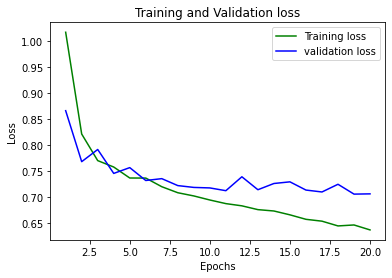

In [40]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

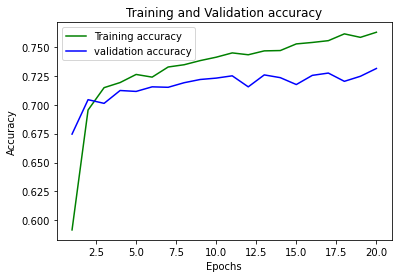

In [41]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

132/132 [==============================] - 1s 5ms/step - loss: 0.7351 - accuracy: 0.7174
accuracy: 71.74%


In [43]:
y_pred = model.predict(X_test)

y_pred = (y_pred > 0.5) 

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1529
           1       0.70      0.53      0.60       923
           2       0.00      0.00      0.00       275
           3       0.78      0.79      0.79      1473

   micro avg       0.76      0.67      0.71      4200
   macro avg       0.56      0.52      0.54      4200
weighted avg       0.71      0.67      0.68      4200
 samples avg       0.67      0.67      0.67      4200



**function for creating confusion matrix**

In [45]:
def print_confusion_matrix(confusion_matrix, class_names, title='Confusion matrix', figsize = (6,6), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title, fontsize=20)
    
    return fig

**printing the confusion matrix**

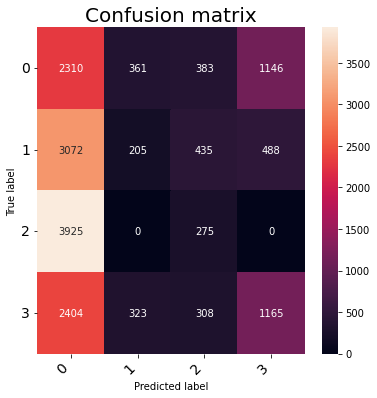

In [46]:
from sklearn.metrics import multilabel_confusion_matrix

cnf_matrix = multilabel_confusion_matrix(y_test, y_pred).reshape(4*1, -1)
classes = [str(x) for x in list(y_test.columns.values.tolist())]

print_confusion_matrix(cnf_matrix, classes);